In [1]:
import numpy as np
import pandas as pd

In [22]:
import evalml
from evalml import AutoMLSearch

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [ ]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("evalml_spam")

In [3]:
data = pd.read_csv('spam.csv',encoding="cp437")

In [4]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [6]:
data.rename(columns={'v1':'Category','v2':'Message'},inplace=True)

In [7]:
X = data.drop(['Category'], axis=1)
y = data['Category']

In [23]:
y.value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Category, dtype: float64

<AxesSubplot:ylabel='Category'>

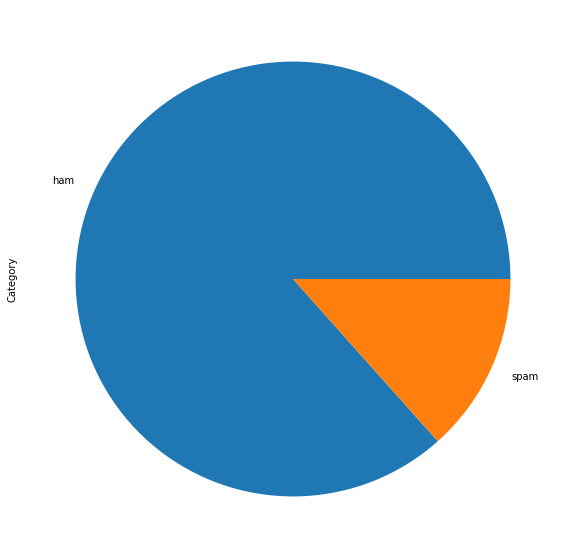

In [8]:
y.value_counts().plot.pie(figsize=(10,10))

In [17]:
#!pip install woodwork

In [14]:
import woodwork as ww

In [24]:
X.ww.init(logical_types={"Message": "NaturalLanguage"})

In [25]:
X_train, X_holdout, y_train, y_holdout = evalml.preprocessing.split_data(
    X, y, problem_type="binary", test_size=0.2, random_seed=0
)

In [26]:
X_train.ww

,Physical Type,Logical Type,Semantic Tag(s)
Column,,,
Message,string,NaturalLanguage,[]


In [53]:
y_train

1257     ham
5461     ham
1612    spam
2179     ham
2638     ham
        ... 
3297    spam
1054     ham
245      ham
1235     ham
3361     ham
Name: Category, Length: 4457, dtype: category
Categories (2, object): ['ham', 'spam']

In [28]:
automl = AutoMLSearch(
    X_train=X_train,
    y_train=y_train,
    problem_type="binary",
    max_batches=1,
    optimize_thresholds=True,
    verbose=True,
)

automl.search()


*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Binary. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 1 batches for a total of None pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 4.634

*****************************
* Evaluating Batch Number 1 *
*****************************

Logistic Regression Classifier w/ Label Encoder + Natural Language Featurizer + Imputer + Oversampler + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.198
Random Forest Classifier w/ Label Encoder + Natural Language Featurizer + Imputer + Oversampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.146

Search finished after 04:59            
Best pipeline: Random Forest Classifier w/ Label Encoder + Natural Language Featurizer + Imputer + Oversampler
Best pipeline Log Loss Binary: 0.146011


In [29]:
automl.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,2,Random Forest Classifier w/ Label Encoder + Na...,2,0.146011,0.006984,0.146011,96.849200,False,"{'Label Encoder': {'positive_label': None}, 'I..."
1,1,Logistic Regression Classifier w/ Label Encode...,1,0.197820,0.004809,0.197820,95.731211,False,"{'Label Encoder': {'positive_label': None}, 'I..."
2,0,Mode Baseline Binary Classification Pipeline,0,4.634100,0.012617,4.634100,0.000000,False,"{'Label Encoder': {'positive_label': None}, 'B..."


In [34]:
best_pipeline = automl.best_pipeline

In [35]:
automl.describe_pipeline(automl.rankings.iloc[0]["id"])


***************************************************************************************************
* Random Forest Classifier w/ Label Encoder + Natural Language Featurizer + Imputer + Oversampler *
***************************************************************************************************

Problem Type: binary
Model Family: Random Forest

Pipeline Steps
1. Label Encoder
	 * positive_label : None
2. Natural Language Featurizer
3. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * boolean_impute_strategy : most_frequent
	 * categorical_fill_value : None
	 * numeric_fill_value : None
	 * boolean_fill_value : None
4. Oversampler
	 * sampling_ratio : 0.25
	 * k_neighbors_default : 5
	 * n_jobs : -1
	 * sampling_ratio_dict : None
	 * k_neighbors : 5
5. Random Forest Classifier
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1

Training
Training for binary problems.
Total training time (including CV): 146.2 seconds

Cross Validatio

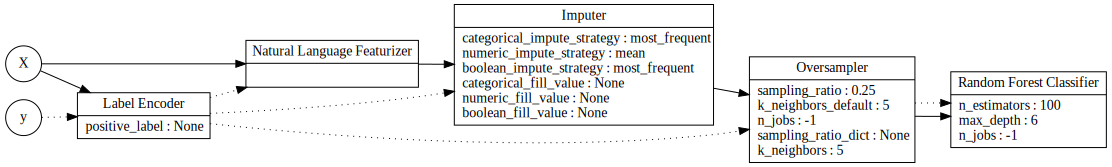

In [48]:
best_pipeline.graph()

In [37]:
scores = best_pipeline.score(
    X_holdout, y_holdout, objectives=evalml.objectives.get_core_objectives("binary")
)
print(f'Accuracy Binary: {scores["Accuracy Binary"]}')

Accuracy Binary: 0.9479820627802691


In [70]:
automl.rankings.iloc[0]["pipeline_name"]

'Random Forest Classifier w/ Label Encoder + Natural Language Featurizer + Imputer + Oversampler'

In [44]:
scores

OrderedDict([('MCC Binary', 0.7683176325175218),
             ('Log Loss Binary', 0.1489465767500509),
             ('Gini', 0.9283004710492309),
             ('AUC', 0.9641502355246154),
             ('Precision', 0.8321167883211679),
             ('F1', 0.7972027972027971),
             ('Balanced Accuracy Binary', 0.8706455736657079),
             ('Accuracy Binary', 0.9479820627802691)])

In [67]:
best_pipeline

pipeline = BinaryClassificationPipeline(component_graph={'Label Encoder': ['Label Encoder', 'X', 'y'], 'Natural Language Featurizer': ['Natural Language Featurizer', 'X', 'Label Encoder.y'], 'Imputer': ['Imputer', 'Natural Language Featurizer.x', 'Label Encoder.y'], 'Oversampler': ['Oversampler', 'Imputer.x', 'Label Encoder.y'], 'Random Forest Classifier': ['Random Forest Classifier', 'Oversampler.x', 'Oversampler.y']}, parameters={'Label Encoder':{'positive_label': None}, 'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'boolean_impute_strategy': 'most_frequent', 'categorical_fill_value': None, 'numeric_fill_value': None, 'boolean_fill_value': None}, 'Oversampler':{'sampling_ratio': 0.25, 'k_neighbors_default': 5, 'n_jobs': -1, 'sampling_ratio_dict': None, 'k_neighbors': 5}, 'Random Forest Classifier':{'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}}, random_seed=0)

In [69]:
best_pipeline.parameters
#['Label Encoder']

{'Label Encoder': {'positive_label': None},
 'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Oversampler': {'sampling_ratio': 0.25,
  'k_neighbors_default': 5,
  'n_jobs': -1,
  'sampling_ratio_dict': None,
  'k_neighbors': 5},
 'Random Forest Classifier': {'n_estimators': 100,
  'max_depth': 6,
  'n_jobs': -1}}

In [38]:
best_pipeline.input_feature_names

{'Label Encoder': ['Message'],
 'Natural Language Featurizer': ['Message'],
 'Imputer': ['DIVERSITY_SCORE(Message)',
  'MEAN_CHARACTERS_PER_WORD(Message)',
  'NUM_CHARACTERS(Message)',
  'NUM_WORDS(Message)',
  'POLARITY_SCORE(Message)',
  'LSA(Message)[0]',
  'LSA(Message)[1]'],
 'Oversampler': ['DIVERSITY_SCORE(Message)',
  'MEAN_CHARACTERS_PER_WORD(Message)',
  'NUM_CHARACTERS(Message)',
  'NUM_WORDS(Message)',
  'POLARITY_SCORE(Message)',
  'LSA(Message)[0]',
  'LSA(Message)[1]'],
 'Random Forest Classifier': ['DIVERSITY_SCORE(Message)',
  'MEAN_CHARACTERS_PER_WORD(Message)',
  'NUM_CHARACTERS(Message)',
  'NUM_WORDS(Message)',
  'POLARITY_SCORE(Message)',
  'LSA(Message)[0]',
  'LSA(Message)[1]']}

In [39]:
natural_language_featurizer = evalml.pipelines.components.NaturalLanguageFeaturizer()
X_featurized = natural_language_featurizer.fit_transform(X_train)

In [40]:
X_train.head()

,Message
1257,Am also doing in cbe only. But have to pay.
5461,Ok i thk i got it. Then u wan me 2 come now or...
1612,RT-KIng Pro Video Club>> Need help? info@ringt...
2179,And popping &lt;#&gt; ibuprofens was no help.
2638,Am in gobi arts college


In [41]:
X_featurized.head()

,DIVERSITY_SCORE(Message),MEAN_CHARACTERS_PER_WORD(Message),NUM_CHARACTERS(Message),NUM_WORDS(Message),POLARITY_SCORE(Message),LSA(Message)[0],LSA(Message)[1]
1257,1.000,3.200000,41.0,10.0,-0.412,0.173654,-0.006241
5461,1.000,2.333333,49.0,15.0,0.306,0.199275,0.143747
1612,0.875,6.050000,140.0,20.0,0.436,0.084530,0.029641
2179,1.000,4.714286,39.0,7.0,0.474,0.105068,0.013377
2638,1.000,3.800000,23.0,5.0,0.000,0.053456,0.014601


In [ ]:
mlflow.sklearn.autog()

In [ ]:
with mlflow.start_run(run_name ="evalml"):
    run_uuid = mlflow.active_run().info.run_uuid
    print("MLflow Run ID: %s" % run_uuid)
    
    # log parameters
    #mlflow.log_param("alpha", 0.001)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("optimizer", opt)
    mlflow.log_param("batch_size", batch_size)
    
    # calculate metrics
    mlflow.log_metric("Accuracy Binary",scores["Accuracy Binary"])
    mlflow.log_metric("precision", scores['Precision'])
    mlflow.log_metric("F1",scores['F1'] )
    mlflow.log_metric('Balanced Accuracy Binary', scores['Balanced Accuracy Binary'])
    
    # log artifacts
    #mlflow.log_artifacts(image_dir, "lstm_images")

    mlflow.sklearn.log_model(automl.rankings.iloc[0]["pipeline_name"],"model_family")
    
   
    

In [42]:
from evalml.utils import infer_feature_types

X = infer_feature_types(X, {"Message": "Categorical"})
X_train, X_holdout, y_train, y_holdout = evalml.preprocessing.split_data(
    X, y, problem_type="binary", test_size=0.2, random_seed=0
)

In [43]:
automl_no_text = AutoMLSearch(
    X_train=X_train,
    y_train=y_train,
    problem_type="binary",
    max_batches=1,
    optimize_thresholds=True,
    verbose=True,
)

automl_no_text.search()


*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Binary. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 1 batches for a total of None pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 4.634

*****************************
* Evaluating Batch Number 1 *
*****************************

Logistic Regression Classifier w/ Label Encoder + Natural Language Featurizer + Imputer + Oversampler + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.198
Random Forest Classifier w/ Label Encoder + Natural Language Featurizer + Imputer + Oversampler:
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.146

Search finished after 05:07            
Best pipeline: Random Forest Classifier w/ Label Encoder + Natural Language Featurizer + Imputer + Oversampler
Best pipeline Log Loss Binary: 0.146011


In [45]:
automl_no_text.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,2,Random Forest Classifier w/ Label Encoder + Na...,2,0.146011,0.006984,0.146011,96.849200,False,"{'Label Encoder': {'positive_label': None}, 'I..."
1,1,Logistic Regression Classifier w/ Label Encode...,1,0.197820,0.004809,0.197820,95.731211,False,"{'Label Encoder': {'positive_label': None}, 'I..."
2,0,Mode Baseline Binary Classification Pipeline,0,4.634100,0.012617,4.634100,0.000000,False,"{'Label Encoder': {'positive_label': None}, 'B..."


In [46]:
best_pipeline_no_text = automl_no_text.best_pipeline

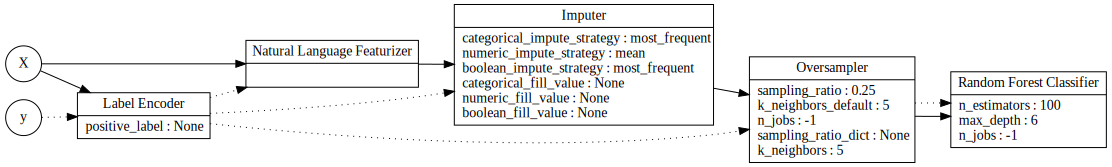

In [47]:
best_pipeline_no_text.graph()

In [49]:
automl_no_text.describe_pipeline(automl_no_text.rankings.iloc[0]["id"])


***************************************************************************************************
* Random Forest Classifier w/ Label Encoder + Natural Language Featurizer + Imputer + Oversampler *
***************************************************************************************************

Problem Type: binary
Model Family: Random Forest

Pipeline Steps
1. Label Encoder
	 * positive_label : None
2. Natural Language Featurizer
3. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * boolean_impute_strategy : most_frequent
	 * categorical_fill_value : None
	 * numeric_fill_value : None
	 * boolean_fill_value : None
4. Oversampler
	 * sampling_ratio : 0.25
	 * k_neighbors_default : 5
	 * n_jobs : -1
	 * sampling_ratio_dict : None
	 * k_neighbors : 5
5. Random Forest Classifier
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1

Training
Training for binary problems.
Total training time (including CV): 152.2 seconds

Cross Validatio

In [51]:
# get standard performance metrics on holdout data
scores_text = best_pipeline_no_text.score(
    X_holdout, y_holdout, objectives=evalml.objectives.get_core_objectives("binary")
)
print(f'Accuracy Binary: {scores_text["Accuracy Binary"]}')

Accuracy Binary: 0.9479820627802691


In [52]:
scores_text

OrderedDict([('MCC Binary', 0.7683176325175218),
             ('Log Loss Binary', 0.14894657675005088),
             ('Gini', 0.9283004710492309),
             ('AUC', 0.9641502355246154),
             ('Precision', 0.8321167883211679),
             ('F1', 0.7972027972027971),
             ('Balanced Accuracy Binary', 0.8706455736657079),
             ('Accuracy Binary', 0.9479820627802691)])